# Chapter 11

# 11.7.3. Bootstrapping and confidence intervals in PK/PD models

Original ka: 1.7425 1/hour
Original ke: 0.1331 1/hour
95% Confidence Interval for ka: [1.39149917 2.48465844]
95% Confidence Interval for ke: [0.10647499 0.15342977]


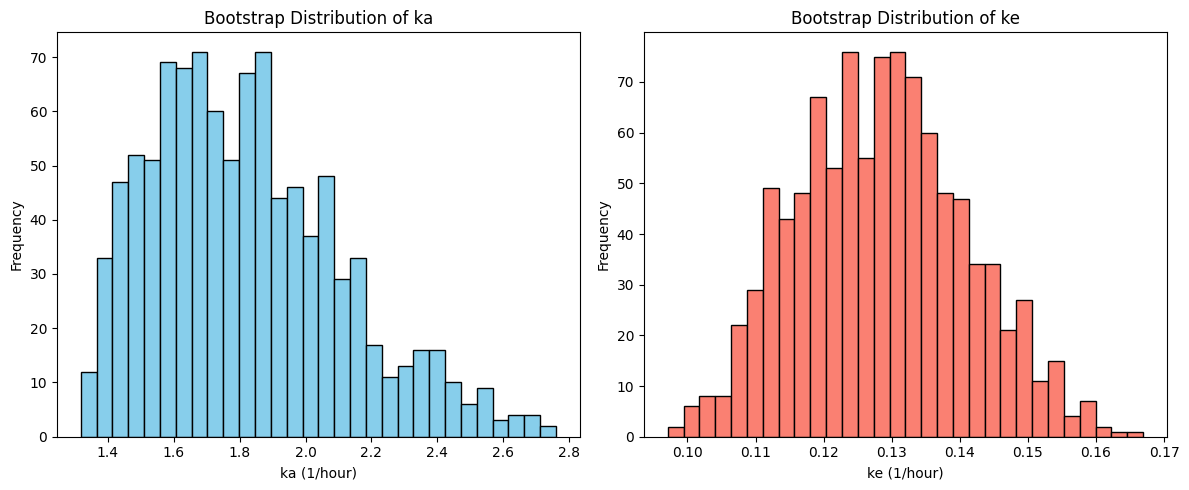

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the PK model
def pk_model(t, ka, ke):
    F = 1.0
    D = 500
    Vd = 50
    if ka == ke:
        return np.zeros_like(t)
    C = (F * D * ka) / (Vd * (ka - ke)) * (np.exp(-ke * t) - np.exp(-ka * t))
    return C

# Experimental data
time_data = np.array([0.5, 1, 2, 4, 6, 8, 12, 24])
concentration_data = np.array([5.1, 8.0, 9.3, 7.2, 4.8, 3.1, 1.5, 0.6])

# Initial parameter estimates
initial_guesses = [1.0, 0.5]

# Fit the original model
params, covariance = curve_fit(pk_model, time_data, concentration_data, p0=initial_guesses, bounds=([0.01, 0.01], [10, 10]))
ka_original, ke_original = params
print(f"Original ka: {ka_original:.4f} 1/hour")
print(f"Original ke: {ke_original:.4f} 1/hour")

# Calculate residuals
fitted_concentration = pk_model(time_data, ka_original, ke_original)
residuals = concentration_data - fitted_concentration

# Number of bootstrap samples
n_bootstraps = 1000

# Storage for bootstrap estimates
ka_bootstrap = []
ke_bootstrap = []

# Perform residual bootstrapping
for _ in range(n_bootstraps):
    # Resample residuals with replacement
    resampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    # Generate new concentration data
    concentration_resample = fitted_concentration + resampled_residuals
    # Ensure no negative concentrations
    concentration_resample = np.maximum(concentration_resample, 0.01)
    
    # Fit the model to the resampled data with bounds
    try:
        params_boot, _ = curve_fit(pk_model, time_data, concentration_resample, p0=initial_guesses, bounds=([0.01, 0.01], [10, 10]))
        ka_bootstrap.append(params_boot[0])
        ke_bootstrap.append(params_boot[1])
    except RuntimeError:
        continue

# Calculate 95% confidence intervals
ka_confidence_interval = np.percentile(ka_bootstrap, [2.5, 97.5])
ke_confidence_interval = np.percentile(ke_bootstrap, [2.5, 97.5])

print(f"95% Confidence Interval for ka: {ka_confidence_interval}")
print(f"95% Confidence Interval for ke: {ke_confidence_interval}")

# Plot histograms of bootstrap estimates
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for ka
ax[0].hist(ka_bootstrap, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Bootstrap Distribution of ka')
ax[0].set_xlabel('ka (1/hour)')
ax[0].set_ylabel('Frequency')

# Histogram for ke
ax[1].hist(ke_bootstrap, bins=30, color='salmon', edgecolor='black')
ax[1].set_title('Bootstrap Distribution of ke')
ax[1].set_xlabel('ke (1/hour)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()